In [1]:
import pandas as pd
hibbs=pd.read_table('hibbs.dat',sep='\s+')
hibbs.head()

,year,growth,vote,inc_party_candidate,other_candidate
0,1952,2.40,44.60,Stevenson,Eisenhower
1,1956,2.89,57.76,Eisenhower,Stevenson
2,1960,0.85,49.91,Nixon,Kennedy
3,1964,4.21,61.34,Johnson,Goldwater
4,1968,3.02,49.60,Humphrey,Nixon


In [2]:
# confidence level
alpha = 0.1

# imports
import statsmodels.formula.api as smf

# runs regression model
reg_model = smf.ols(formula='vote ~ growth', data=hibbs)
ols = reg_model.fit()

# classical parametric confidence interval
param_ci = ols.get_prediction(hibbs).conf_int(alpha=alpha)


In [3]:
import numpy as np
# nonparametric bootstrap confidence interval
import statsmodels.api as sm

# bootstrap function
def boot_fun(N):
    result=[]
    for i in range(N):
        idx=np.random.choice(np.arange(len(hibbs)), size=len(hibbs), replace=True)
        # run ols on sample
        x=hibbs.iloc[idx,].growth.values
        y=hibbs.iloc[idx,].vote.values
        X   = sm.add_constant(x)
        ols_boot = sm.OLS(y, X).fit()
        # predict and append result
        yhat_boot=ols_boot.predict(sm.add_constant(hibbs.growth.values))
        result.append(yhat_boot)
    return result

# replicate 10,000 times
boot_out=boot_fun(10000)

# quantile confidence interval
quantiles=np.quantile(boot_out,[alpha/2,1-alpha/2],axis=0)
boot_lwr,boot_upr=quantiles[0],quantiles[1]

In [4]:
# data for plot
ci_data=pd.DataFrame({'growth':hibbs['growth'],'vote':hibbs['vote'],'boot_lwr':boot_lwr,
                      'boot_upr':boot_upr,'param_lwr':param_ci[:,0],'param_upr':param_ci[:,1],'fit':ols.fittedvalues})
ci_data=ci_data.sort_values("growth")

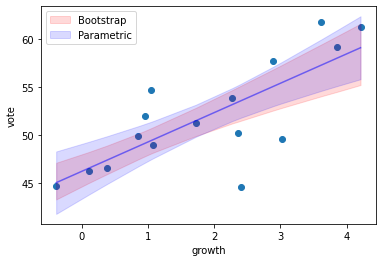

In [5]:
from matplotlib import pyplot as plt
# plot
plt.scatter(ci_data['growth'],ci_data['vote'])
plt.plot(ci_data['growth'],ci_data['fit'],color='b',alpha=0.5)
plt.fill_between(ci_data['growth'], ci_data['boot_lwr'], ci_data['boot_upr'], color='r',alpha=0.15,label='Bootstrap')
plt.fill_between(ci_data['growth'], ci_data['param_lwr'], ci_data['param_upr'], color='b',alpha=0.15,label='Parametric')
plt.xlabel('growth')
plt.ylabel('vote')
plt.legend(loc='upper left')
plt.show()

In [6]:
# classical parametric prediction interval
param_pi=ols.get_prediction(hibbs).summary_frame(0.1)[['obs_ci_lower','obs_ci_upper']]

In [7]:
import statsmodels.api as sm
# Define Conformal Inference Functions

## Conformal Test
def test_y0(y,x,y0,x0,alpha=0.1):
    n=len(y)
    xx=np.append(x,x0)
    yy=np.append(y,y0)
    # add a constant to covariates
    X=sm.add_constant(xx)
    # fit ols model
    ols = sm.OLS(yy, X).fit()
    res=np.abs(ols.resid)
    res_y0=res[n]
    pi_y=np.mean(res_y0>=res)
    include = pi_y*(n + 1) <= np.ceil((1 - alpha)*(n + 1))
    return include

## Loop over all x0 and a grid of test values for y0
def conformalInterval(y, x, x0, alpha = 0.1, length = 100, scale = 1):
    y_max=np.max(np.abs(y))*scale
    y0=np.linspace(-y_max,y_max,length)
    out=[]
    for j in range(len(x0)):
        include=np.zeros(len(y0),dtype=bool)
        for i in range(len(y0)):
            include[i]=test_y0(y,x,y0[i],x0[j],alpha=0.1)
        out.append(y0[include])
    return out

In [8]:
# compute conformal interval
conf_out = conformalInterval(y = hibbs.vote.values, x = hibbs.growth.values, x0 = hibbs.growth.values, alpha = 0.1)
conf_lwr, conf_upr=[np.min(i) for i in conf_out],[np.max(i) for i in conf_out]


In [9]:
# data for plot
pi_data=pd.DataFrame({'growth':hibbs['growth'],'vote':hibbs['vote'],'conf_lwr':conf_lwr,
                      'conf_upr':conf_upr,'param_lwr':param_pi['obs_ci_lower'],
                      'param_upr':param_pi['obs_ci_upper'],'fit':ols.fittedvalues})
pi_data=pi_data.sort_values("growth")

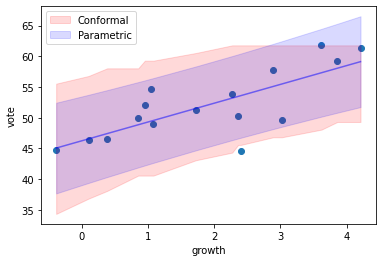

In [10]:
# plot
plt.scatter(pi_data['growth'],pi_data['vote'])
plt.plot(pi_data['growth'],pi_data['fit'],color='b',alpha=0.5)
plt.fill_between(pi_data['growth'], pi_data['conf_lwr'], pi_data['conf_upr'], color='r',alpha=0.15,label='Conformal')
plt.fill_between(pi_data['growth'], pi_data['param_lwr'], pi_data['param_upr'], color='b',alpha=0.15,label='Parametric')
plt.xlabel('growth')
plt.ylabel('vote')
plt.legend(loc='upper left')
plt.show()